In [69]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models

#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020322")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}



emb = all_embs[emb_models[1]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
emb_down = ee.resample_data(emb,1)

In [65]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=50, init='pca', learning_rate=emb_down.shape[0]//12)

In [ ]:
#run umap with default parameters
emb_umap = dr.run_umap(emb_down)

In [66]:
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy()

low_dim = emb_tsne.drop(columns='part_id').to_numpy()
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes,'tsne',subsetsize=emb_down.shape[0])

low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes,'umap',subsetsize=emb_down.shape[0])

In [67]:
#'knn', 'knc', 'cpd' are micro, meso, and marco structure per Kobak&Berens2019
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap)), columns = ['micro', 'meso', 'macro','dim_reduc'], index = ['tsne', 'umap'])
dist

,micro,meso,macro,dim_reduc
tsne,0.5859685863874345,0.6722222222222223,0.560778014836669,tsne
umap,0.4980104712041885,0.5777777777777777,0.2931653590354643,umap


[Text(0.5, 1.0, '                   micro                meso               macro\numap  0.4980104712041885  0.5777777777777777  0.2931653590354643')]

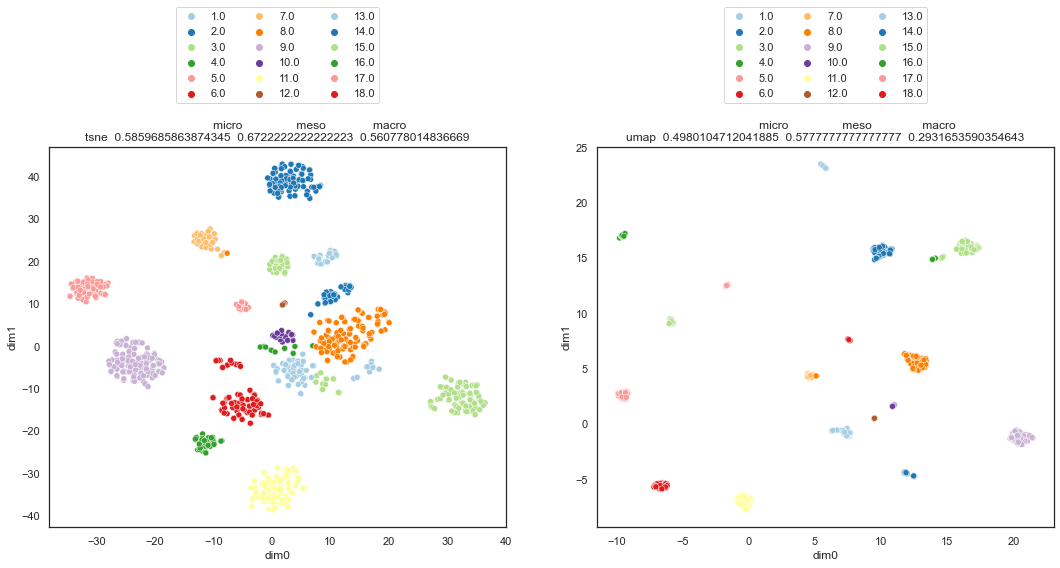

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax1, palette="Paired", hue=emb_tsne.part_id)
ax1.legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)
clust_plt_tsne.set(title = str(dist[dist.dim_reduc=='tsne'].drop(columns='dim_reduc')))

clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax2, palette="Paired", hue=emb_umap.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)
clust_plt_umap.set(title = str(dist[dist.dim_reduc=='umap'].drop(columns='dim_reduc')))


In [60]:
dist.dim_reduc

tsne    tsne
umap    umap
Name: dim_reduc, dtype: object

<AxesSubplot:>

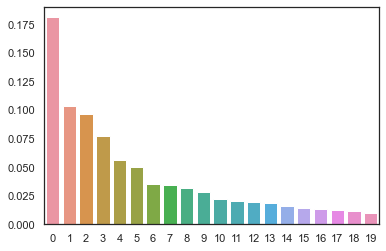

In [81]:
pca = PCA(n_components=512)
exp_var = pca.fit(emb_down.drop(columns='part_id')).explained_variance_ratio_
sns.barplot(x=np.arange(20), y=exp_var[0:20])

In [ ]:
fig, ax = plt.subplots(figsize=(18,7))
emb_pca = pd.DataFrame(pca.fit_transform(emb_down.drop(columns='part_id')))
emb_pca = emb_pca.iloc[:,:2]
emb_pca.columns = ['dim0', 'dim1']

sns.scatterplot(x=emb_pca.dim0, y=emb_pca.dim1, palette="Paired", hue=emb_tsne.part_id)